In [111]:
# Import Libraries
import fastf1
from tqdm import tqdm
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [112]:
def get_cals(year):
    ''' Get the calendar for the year and split it into past and future rounds '''
    calendar = fastf1.events.get_event_schedule(year)
    max_round = calendar['RoundNumber'].max()
    # get curr round
    todays_calendar = fastf1.events.get_event_schedule(datetime.today().year)
    curr_year_max_round = todays_calendar['RoundNumber'].max()
    todays_calendar = todays_calendar[todays_calendar['EventDate'] <= datetime.today()-timedelta(days=1)]
    curr_round = todays_calendar['RoundNumber'].max()
    rounds_left = curr_year_max_round - curr_round
    # proceed to get calendar split
    split_round = max_round - rounds_left
    calendar = calendar[calendar['RoundNumber'] > 0]
    calendar = calendar[['RoundNumber', 'OfficialEventName', 'EventFormat', 'EventDate']]
    prev_cal = calendar[calendar['RoundNumber'] <= split_round]
    future_cal = calendar[calendar['RoundNumber'] > split_round]   
    return prev_cal, future_cal

def get_race_points(year, roundNumber):
    ''' Get the points for the target race'''
    race = fastf1.get_event(year, roundNumber).get_race()
    # Sometimes there are errors loading data, so we retry a few times
    max_retries = 5
    for attempt in range(max_retries):
        try:
            race.load(laps=False, telemetry=False, weather=False, messages=False)
            break
        except Exception as e:
            if attempt < max_retries - 1:
                continue
            else:
                raise e
    # continue after data loaded
    results = race.results
    results = results[['Abbreviation', 'Points']]
    results = results.set_index('Abbreviation')['Points'].to_dict()
    return results

def get_points(year, cal):
    ''' Get the points for an entire year of races '''
    points = {}
    for i, row in cal.iterrows():
        roundNum = row['RoundNumber']
        results = get_race_points(year, roundNum)
        for k,v in results.items():
            if k not in points:
                points[k] = []
            points[k].append(v)
    if 'nan' in points:
        del points['nan']
    return points

def ema(data, alpha):
    ''' Calculate the Exponential Moving Average '''
    if not data:
        return []
    ema_values = [data[0]]  # seed our result with the first data value
    for value in data[1:]:
        previous_ema = ema_values[-1]
        ema_values.append((1 - alpha) * previous_ema + alpha * value)
    return ema_values[-1]

def get_points_rate(prev_points, alpha):
    ''' Calculate the rate of points for each driver '''
    prev_points = {k:ema(v, alpha) for k,v in prev_points.items()}
    df = pd.DataFrame(list(prev_points.items()), columns=['driverCode', 'Points_Rate'])
    return df[df['driverCode'] != 'nan']

def get_remaining(df):
    ''' Get the number of remaining standard and sprint races '''
    num_sprints = (df['EventFormat'] == 'sprint_shootout').sum()
    num_stds = (df['EventFormat'] != 'sprint_shootout').sum()
    return num_stds, num_sprints

def get_drivers_standings(year):
    ''' Get the current driver standings '''
    ergast = fastf1.ergast.Ergast()
    standings = ergast.get_driver_standings(season=year)
    standings = standings.content[0]
    standings['constructorNames'] = standings['constructorNames'].apply(lambda x: x[0])
    return standings[['driverCode', 'constructorNames', 'points']]

def predict_curr_season(year, alpha=0.3):
    ''' Predict the final points for the current season '''
    prev_cal, future_cal = get_cals(year)
    points = get_points(year, prev_cal)
    rates = get_points_rate(points, alpha)
    standings = get_drivers_standings(year)
    df = standings.merge(rates, how='inner', on='driverCode')
    num_std, num_sprints = get_remaining(future_cal)
    df['final_points'] = df['points'] + ((df['Points_Rate'] * num_std) + (df['Points_Rate'] * num_sprints * 1.30769))
    df['final_points'] = df['final_points'].fillna(0.0).round().astype(int)
    df = df.sort_values('final_points', ascending=False)
    df = df.rename(columns={
        'driverCode' : 'Driver',
        'constructorNames' : 'Constructor',
        'points' : 'Current Points',
        'Points_Rate'	: 'Recent Rate of Points',
        'final_points' : 'Estimated Final Points'
    })
    df = df.reset_index(drop=True)
    df.index = df.index + 1
    return df

def find_alpha(year, alpha_ranges):
    ''' Find the best alpha value for the given year '''
    prev_cal, future_cal = get_cals(year)
    prev_points = get_points(year, prev_cal)
    future_points = get_points(year, future_cal)
    future_points = {k : (sum(v) / len(v)) for k,v in future_points.items()}
    alpha_results = {}
    for a in tqdm(alpha_ranges):
        rates = get_points_rate(prev_points, a)
        diff = []
        for k,v in future_points.items():
            if k in set(rates['driverCode'].unique()):
                error = abs(rates.loc[rates['driverCode'] == k, 'Points_Rate'].item() - v)
            diff.append(error)
        diff = sum(diff) / len(diff)
        alpha_results[a] = diff
    return sorted(alpha_results.items(), key=lambda item: item[1])

def check_multiple_alphas(years, alpha_ranges):
    ''' Check multiple alpha values for multiple years '''
    alpha_res = []
    for y in years:
        print(y)
        res = find_alpha(y, alpha_ranges)
        alpha_res.append(res[0][0])
    return alpha_res

In [113]:
# Set recalculte to true to recalculate the optimal alpha value
recalculate = False

if recalculate:
    # Search for the best alpha value for each year
    alpha_searches = [i/100 for i in range(5, 90)]
    years = [2018, 2019, 2020, 2021, 2022]
    best_alphas = check_multiple_alphas(years, alpha_searches)
    # Calculate the optimal alpha value
    optimal_alpha = sum(best_alphas) / len(best_alphas)
else:
    # caclulated on 2018-22 at 2024-05-09
    optimal_alpha = 0.17
optimal_alpha

0.17

In [114]:
# Predict the final points for the current season
target_year = datetime.today().year
df = predict_curr_season(target_year, optimal_alpha)
# remove drivers who have left the season or are substitutes
df = df[~df['Driver'].isin(['BEA','SAR','COL'])].reset_index(drop=True)
df

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.1.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
Request for URL https://ergast.com/api/f1/2024/1/results.json failed; using cached response
Traceback (most recent call last):
  File "c:\Users\natha\.conda\envs\f1\lib\site-packages\requests_cache\session.py", line 255, in _resend
    response = self._send_and_cache(request, actions, cached_response, **kwargs)
  File "c:\Users\natha\.conda\envs\f1\lib\site-packages\requests_cache\session.py", line 229, in _send_and_cache
    response = super().send(request, **kwargs)
  File "c:\Users\natha\.conda\envs\f1\lib\site-packages\fastf1\req.py", line 122, in send
    lim.limit()
  File "c:\Users\natha\.conda\envs\f1\lib\site-packages\fastf1\req.py", line 99, in limit
    raise RateLimitExceededError(self._info)
fastf1.req.RateLimitExceededError: ergast.com: 200 calls/h
core           INFO 	Finished loading data 

,Driver,Constructor,Current Points,Recent Rate of Points,Estimated Final Points
0,VER,Red Bull,303.0,15.439247,427
1,NOR,McLaren,241.0,15.437944,365
2,LEC,Ferrari,217.0,13.376066,324
3,PIA,McLaren,197.0,14.066112,310
4,SAI,Ferrari,184.0,10.631108,269
5,HAM,Mercedes,164.0,12.109384,261
6,PER,Red Bull,143.0,6.411322,194
7,RUS,Mercedes,128.0,7.091998,185
8,ALO,Aston Martin,50.0,1.960443,66
9,STR,Aston Martin,24.0,1.103402,33


In [115]:
# Calculate the position change for each driver
df = df.sort_values('Current Points', ascending=False).reset_index(drop=True)
df['Current Position'] = df.index + 1
df = df.sort_values('Estimated Final Points', ascending=False).reset_index(drop=True)
df['Estimated Position'] = df.index + 1
df['Position Change'] = df['Current Position'] - df['Estimated Position']
df

,Driver,Constructor,Current Points,Recent Rate of Points,Estimated Final Points,Current Position,Estimated Position,Position Change
0,VER,Red Bull,303.0,15.439247,427,1,1,0
1,NOR,McLaren,241.0,15.437944,365,2,2,0
2,LEC,Ferrari,217.0,13.376066,324,3,3,0
3,PIA,McLaren,197.0,14.066112,310,4,4,0
4,SAI,Ferrari,184.0,10.631108,269,5,5,0
5,HAM,Mercedes,164.0,12.109384,261,6,6,0
6,PER,Red Bull,143.0,6.411322,194,7,7,0
7,RUS,Mercedes,128.0,7.091998,185,8,8,0
8,ALO,Aston Martin,50.0,1.960443,66,9,9,0
9,STR,Aston Martin,24.0,1.103402,33,10,10,0


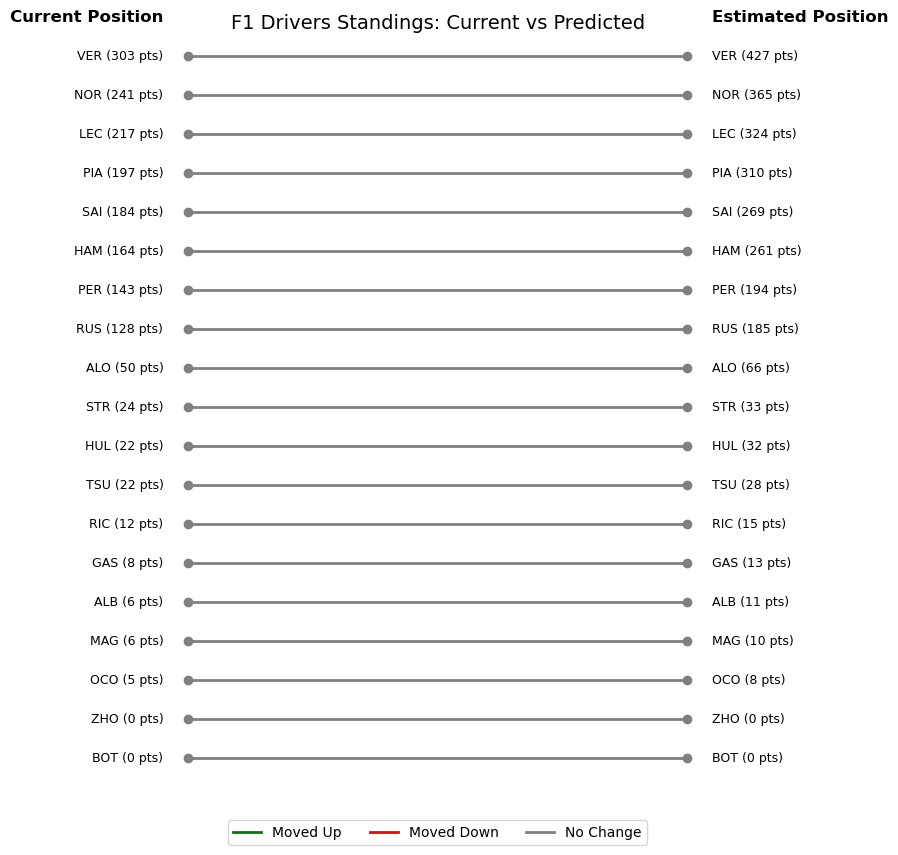

In [116]:
''' Plot the bump chart for drivers championship '''
# Map drivers to their current and estimated positions and points
current_positions = df.set_index('Driver')['Current Position'].to_dict()
estimated_positions = df.set_index('Driver')['Estimated Position'].to_dict()
position_changes = df.set_index('Driver')['Position Change'].to_dict()
current_points = df.set_index('Driver')['Current Points'].to_dict()
estimated_points = df.set_index('Driver')['Estimated Final Points'].to_dict()

# List of drivers
drivers = df['Driver'].unique()
n_drivers = len(drivers)

# Initialise the plot
fig, ax = plt.subplots(figsize=(9, n_drivers * 0.45))

# Plot lines connecting current and estimated positions
for driver in drivers:
    y_start = current_positions[driver] - 1  # Zero-based indexing
    y_end = estimated_positions[driver] - 1
    change = position_changes[driver]
    
    # Determine color based on position change
    if change > 0:
        color = 'green'
    elif change < 0:
        color = 'red'
    else:
        color = 'gray'

    # Plot the line
    ax.plot([0, 1], [y_start, y_end], marker='o', color=color, linewidth=2)

    # Prepare annotation text with driver name and points
    left_label = f"{driver} ({int(current_points[driver])} pts)"
    right_label = f"{driver} ({int(estimated_points[driver])} pts)"

    # Annotate driver names with points
    ax.text(-0.05, y_start, left_label, ha='right', va='center', fontsize=9)
    ax.text(1.05, y_end, right_label, ha='left', va='center', fontsize=9)

# Customise the plot
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(n_drivers - 0.5, -0.5)  # Reverse y-axis
ax.axis('off')
ax.set_title('F1 Drivers Standings: Current vs Predicted', fontsize=14)

# Add labels for the two sides
ax.text(-0.05, -1, 'Current Position', ha='right', va='center', fontsize=12, fontweight='bold')
ax.text(1.05, -1, 'Estimated Position', ha='left', va='center', fontsize=12, fontweight='bold')

# Add a legend for the color coding
legend_elements = [
    Line2D([0], [0], color='green', lw=2, label='Moved Up'),
    Line2D([0], [0], color='red', lw=2, label='Moved Down'),
    Line2D([0], [0], color='gray', lw=2, label='No Change')
]
ax.legend(handles=legend_elements, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.show()

In [117]:
# Transform to constructor standings
teams_df = df.drop(columns=['Driver'])
teams_df = teams_df.groupby('Constructor').sum()
teams_df = teams_df.reset_index().sort_values('Estimated Final Points', ascending=False).reset_index(drop=True)
teams_df['Estimated Position'] = teams_df.index + 1
teams_df = teams_df.sort_values('Current Points', ascending=False).reset_index(drop=True)
teams_df['Current Position'] = teams_df.index + 1
teams_df['Position Change'] = teams_df['Current Position'] - teams_df['Estimated Position']
teams_df

,Constructor,Current Points,Recent Rate of Points,Estimated Final Points,Current Position,Estimated Position,Position Change
0,Red Bull,446.0,21.850568,621,1,2,-1
1,McLaren,438.0,29.504056,675,2,1,1
2,Ferrari,401.0,24.007174,593,3,3,0
3,Mercedes,292.0,19.201383,446,4,4,0
4,Aston Martin,74.0,3.063845,99,5,5,0
5,RB F1 Team,34.0,1.162516,43,6,6,0
6,Haas F1 Team,28.0,1.698655,42,7,7,0
7,Alpine F1 Team,13.0,0.953189,21,8,8,0
8,Williams,6.0,0.577936,11,9,9,0
9,Sauber,0.0,0.000000,0,10,10,0


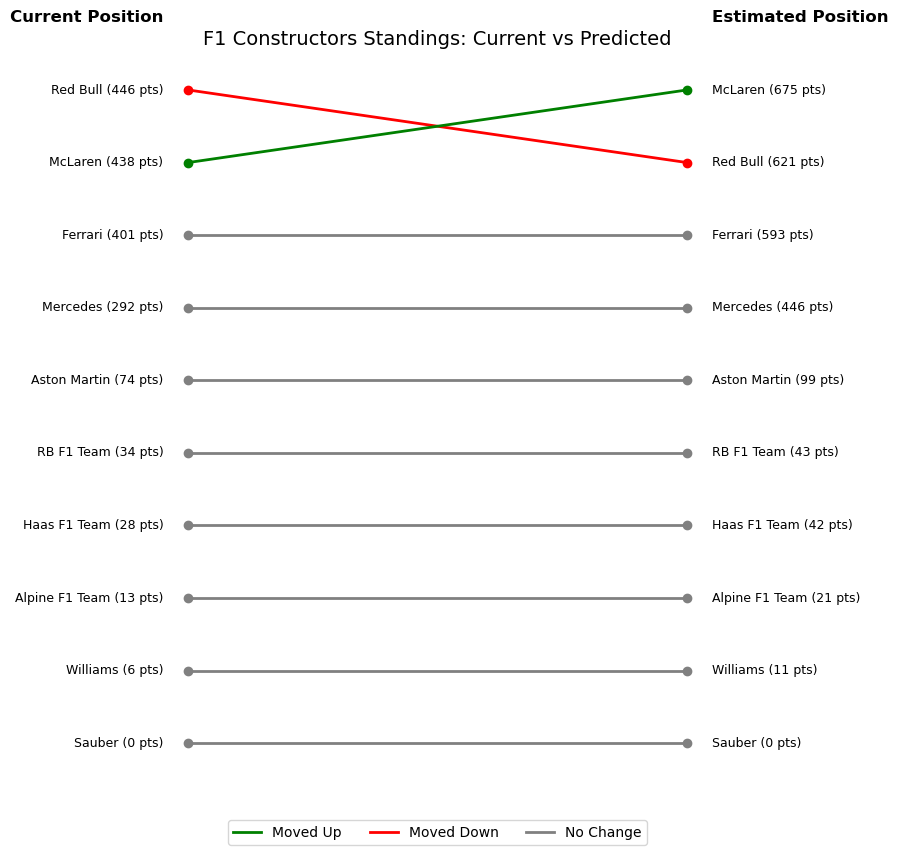

In [118]:
''' Plot the bump chart for constructors championship '''
# Map drivers to their current and estimated positions and points
current_positions = teams_df.set_index('Constructor')['Current Position'].to_dict()
estimated_positions = teams_df.set_index('Constructor')['Estimated Position'].to_dict()
position_changes = teams_df.set_index('Constructor')['Position Change'].to_dict()
current_points = teams_df.set_index('Constructor')['Current Points'].to_dict()
estimated_points = teams_df.set_index('Constructor')['Estimated Final Points'].to_dict()

# List of drivers
constructors = teams_df['Constructor'].unique()
n_constructors = len(constructors)

# Initialize the plot
fig, ax = plt.subplots(figsize=(9, n_drivers * 0.45))

# Plot lines connecting current and estimated positions
for constructor in constructors:
    y_start = current_positions[constructor] - 1  # Zero-based indexing
    y_end = estimated_positions[constructor] - 1
    change = position_changes[constructor]
    
    # Determine color based on position change
    if change > 0:
        color = 'green'
    elif change < 0:
        color = 'red'
    else:
        color = 'gray'

    # Plot the line
    ax.plot([0, 1], [y_start, y_end], marker='o', color=color, linewidth=2)

    # Prepare annotation text with driver name and points
    left_label = f"{constructor} ({int(current_points[constructor])} pts)"
    right_label = f"{constructor} ({int(estimated_points[constructor])} pts)"

    # Annotate driver names with points
    ax.text(-0.05, y_start, left_label, ha='right', va='center', fontsize=9)
    ax.text(1.05, y_end, right_label, ha='left', va='center', fontsize=9)

# Customize the plot
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(n_constructors - 0.5, -0.5)  # Reverse y-axis
ax.axis('off')
ax.set_title('F1 Constructors Standings: Current vs Predicted', fontsize=14)

# Add labels for the two sides
ax.text(-0.05, -1, 'Current Position', ha='right', va='center', fontsize=12, fontweight='bold')
ax.text(1.05, -1, 'Estimated Position', ha='left', va='center', fontsize=12, fontweight='bold')

# Add a legend for the color coding
legend_elements = [
    Line2D([0], [0], color='green', lw=2, label='Moved Up'),
    Line2D([0], [0], color='red', lw=2, label='Moved Down'),
    Line2D([0], [0], color='gray', lw=2, label='No Change')
]
ax.legend(handles=legend_elements, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.show()